# 0.0 Imports

In [163]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display              import Image
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

## Helper functions

In [109]:
def chi2(data, col1, col2):
    contingency_table = pd.crosstab(data[col1], data[col2])
    return chi2_contingency(contingency_table)


def scatterplot(data, col1, col2, hue='none'):
    plt.figure(figsize=(20, 8))
    
    if hue == 'none':
        sns.scatterplot(data=data, x=col1, y=col2)
    else:
        sns.scatterplot(data=data, x=col1, y=col2, hue=hue)

    plt.show()

    
def cramer_v(data, x, y):
    cm = pd.crosstab(data[x], data[y]).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))


def contingency_coef(data, col1, col2):
    obs = pd.crosstab(data[col1], data[col2])
    chi2, p, dof, expected = chi2_contingency(obs)
    n = obs.sum()
    cont_coef = np.sqrt(chi2 / (n * (min(obs.shape)-1)))
    return cont_coef


def print_ht(p, alpha=0.05):
    print(f'P-value: {p:.10f}')

    if p < alpha:
        print('There is a significant association between the two variables analysed.')
    else:
        print('There is no significant association between the two variables analysed.')

        
def countplot(data, col, hue='none'):
    plt.figure(figsize=(20, 8))
    
    if hue == 'none':
        sns.countplot(data=data, x=col)
    else:
        sns.countplot(data=data, x=col, hue=hue)
        
    plt.xticks(rotation=90)
        
    plt.show()

# 1.0 Data Collection

### Database connection

In [4]:
# host = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
# port = 5432
# database = "comunidadedsdb"
# username = "member"
# password = "cdspa"

# conn = psycopg2.connect(
#             host=host,
#             port=port,
#             database=database,
#             user=username,
#             password=password
#         )

# cursor = conn.cursor()

### Getting existing tables from 'pa004' schema

In [5]:
# cursor.execute(
#     "SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname NOT IN ('pg_catalog', 'information_schema', 'public');"
# )

# rows = cursor.fetchall()

# for row in rows:
#     print(row[0])

### Getting all data from 'users' table

In [6]:
# cursor.execute(
#     "SELECT * FROM pa004.insurance LIMIT 5"
# )

In [7]:
# for row in cursor.fetchall():
#     print(row)

### Getting tables as Pandas Dataframes

In [8]:
# df_users = pd.read_sql("SELECT * FROM pa004.users", conn)
# df_vehicle = pd.read_sql("SELECT * FROM pa004.vehicle", conn)
# df_insurance = pd.read_sql("SELECT * FROM pa004.insurance", conn)

In [9]:
# df_users.to_csv("./data/users.csv")
# df_vehicle.to_csv("./data/vehicle.csv")
# df_insurance.to_csv("./data/insurance.csv")

# 2.0 Data Loading

In [10]:
df_users = pd.read_csv("../data/users.csv")
df_users.drop("Unnamed: 0", axis=1, inplace=True)

df_vehicle = pd.read_csv("../data/vehicle.csv")
df_vehicle.drop("Unnamed: 0", axis=1, inplace=True)

df_insurance = pd.read_csv("../data/insurance.csv")
df_insurance.drop("Unnamed: 0", axis=1, inplace=True)

df_raw = pd.merge(pd.merge(df_users, df_vehicle, on='id'), df_insurance, on='id')

# 3.0 Data description and data cleaning

In [11]:
df1 = df_raw.copy()

## Data Dictionary

* <b> Id  </b> - Unique ID for the customer
* <b> Gender </b>  - Gender of the customer
* <b> Age </b> 	- Age of the customer
* <b> Driving_License </b>  - 0 : Customer does not have DL, 1 : Customer already has DL
* <b> Region_Code </b>  - Unique code for the region of the customer
* <b> Previously_Insured </b>  - 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* <b> Vehicle_Age </b>  - Age of the Vehicle
* <b> Vehicle_Damage </b>  - 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* <b> Annual_Premium </b>  - The amount customer needs to pay as premium in the year
* <b> Policy_Sales_Channel </b>  - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* <b> Vintage </b>  - Number of Days, Customer has been associated with the company
* <b> Response </b>  - 1 : Customer is interested, 0 : Customer is not interested

## 3.1 Data dimension

In [12]:
shape = df1.shape
print(f'Number of rows: {shape[0]}')
print(f'Number of columns: {shape[1]}')

Number of rows: 381109
Number of columns: 12


## 3.2 Data types

In [13]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

* We don't need to make any datatype changes.

## 3.3 Missing data

In [14]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

* No missing data.

## 3.4 Duplicates

In [15]:
df1.duplicated().any()

False

* No duplicates.

## 3.5 Descriptive statistics

### 3.4.1 Numeric and categoric attributes

In [16]:
cat_columns = ['gender', 'region_code', 'policy_sales_channel', 'driving_license', 'vehicle_age', 
               'vehicle_damage', 'previously_insured', 'response']

num_columns = ['age', 'annual_premium', 'vintage']

In [17]:
cat_attributes = df1[cat_columns]
num_attributes = df1[num_columns]

### 3.4.2 Numeric attributes

#### Central Tendency

In [18]:
central_tendency = num_attributes.describe().loc[['mean', '50%']].T
central_tendency.rename(columns={'50%':'median'}, inplace=True)

#### Dispersion measures

In [19]:
dispersion = num_attributes.describe().loc[['min', 'max', 'std']].T
dispersion['range'] = dispersion.apply(lambda x: x['max'] - x['min'], axis=1)

#### Quantiles

In [20]:
quantiles = num_attributes.describe().loc[['25%', '75%']].T

#### Skewness & Kurtosis

In [21]:
skewness_kurtosis = pd.DataFrame()
skewness_kurtosis['skewness'] = num_attributes.apply(lambda x: x.skew())
skewness_kurtosis['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())

#### All metrics

In [22]:
numeric_metrics = pd.concat([central_tendency, dispersion, quantiles, skewness_kurtosis], axis=1)
numeric_metrics.reset_index(inplace=True)
numeric_metrics.rename(columns={'index':'attributes'}, inplace=True)
numeric_metrics = numeric_metrics[['attributes', 'mean', '25%', 'median', '75%', 'min', 'max', 'range', 'std', 'skewness', 'kurtosis']]

In [23]:
numeric_metrics

,attributes,mean,25%,median,75%,min,max,range,std,skewness,kurtosis
0,age,38.822584,25.0,36.0,49.0,20.0,85.0,65.0,15.511611,0.672539,-0.565655
1,annual_premium,30564.389581,24405.0,31669.0,39400.0,2630.0,540165.0,537535.0,17213.155057,1.766087,34.004569
2,vintage,154.347397,82.0,154.0,227.0,10.0,299.0,289.0,83.671304,0.003030,-1.200688


* annual_premium - o valor máximo é 540.000, enquanto o percentil 75 é 39.400, exibindo uma grande discrepância. Possivelmente essa variável possui outliers, que serão investigados posteriormente.

* annual_premium - um kurtosis de 34 indica que essa distribuição é extremamente empinada em relação a distribuição normal. Isso significa que os valores se concentram muito perto da média e que as caudas são pesadas,  o que significa que há uma alta probabilidade de valores extremos ou outliers.

### 3.4.3 Categoric attributes

#### Nº of categories for each cat col

In [24]:
cat_attributes.apply(lambda x: x.nunique())

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
previously_insured        2
response                  2
dtype: int64

#### Frequency for each cat col

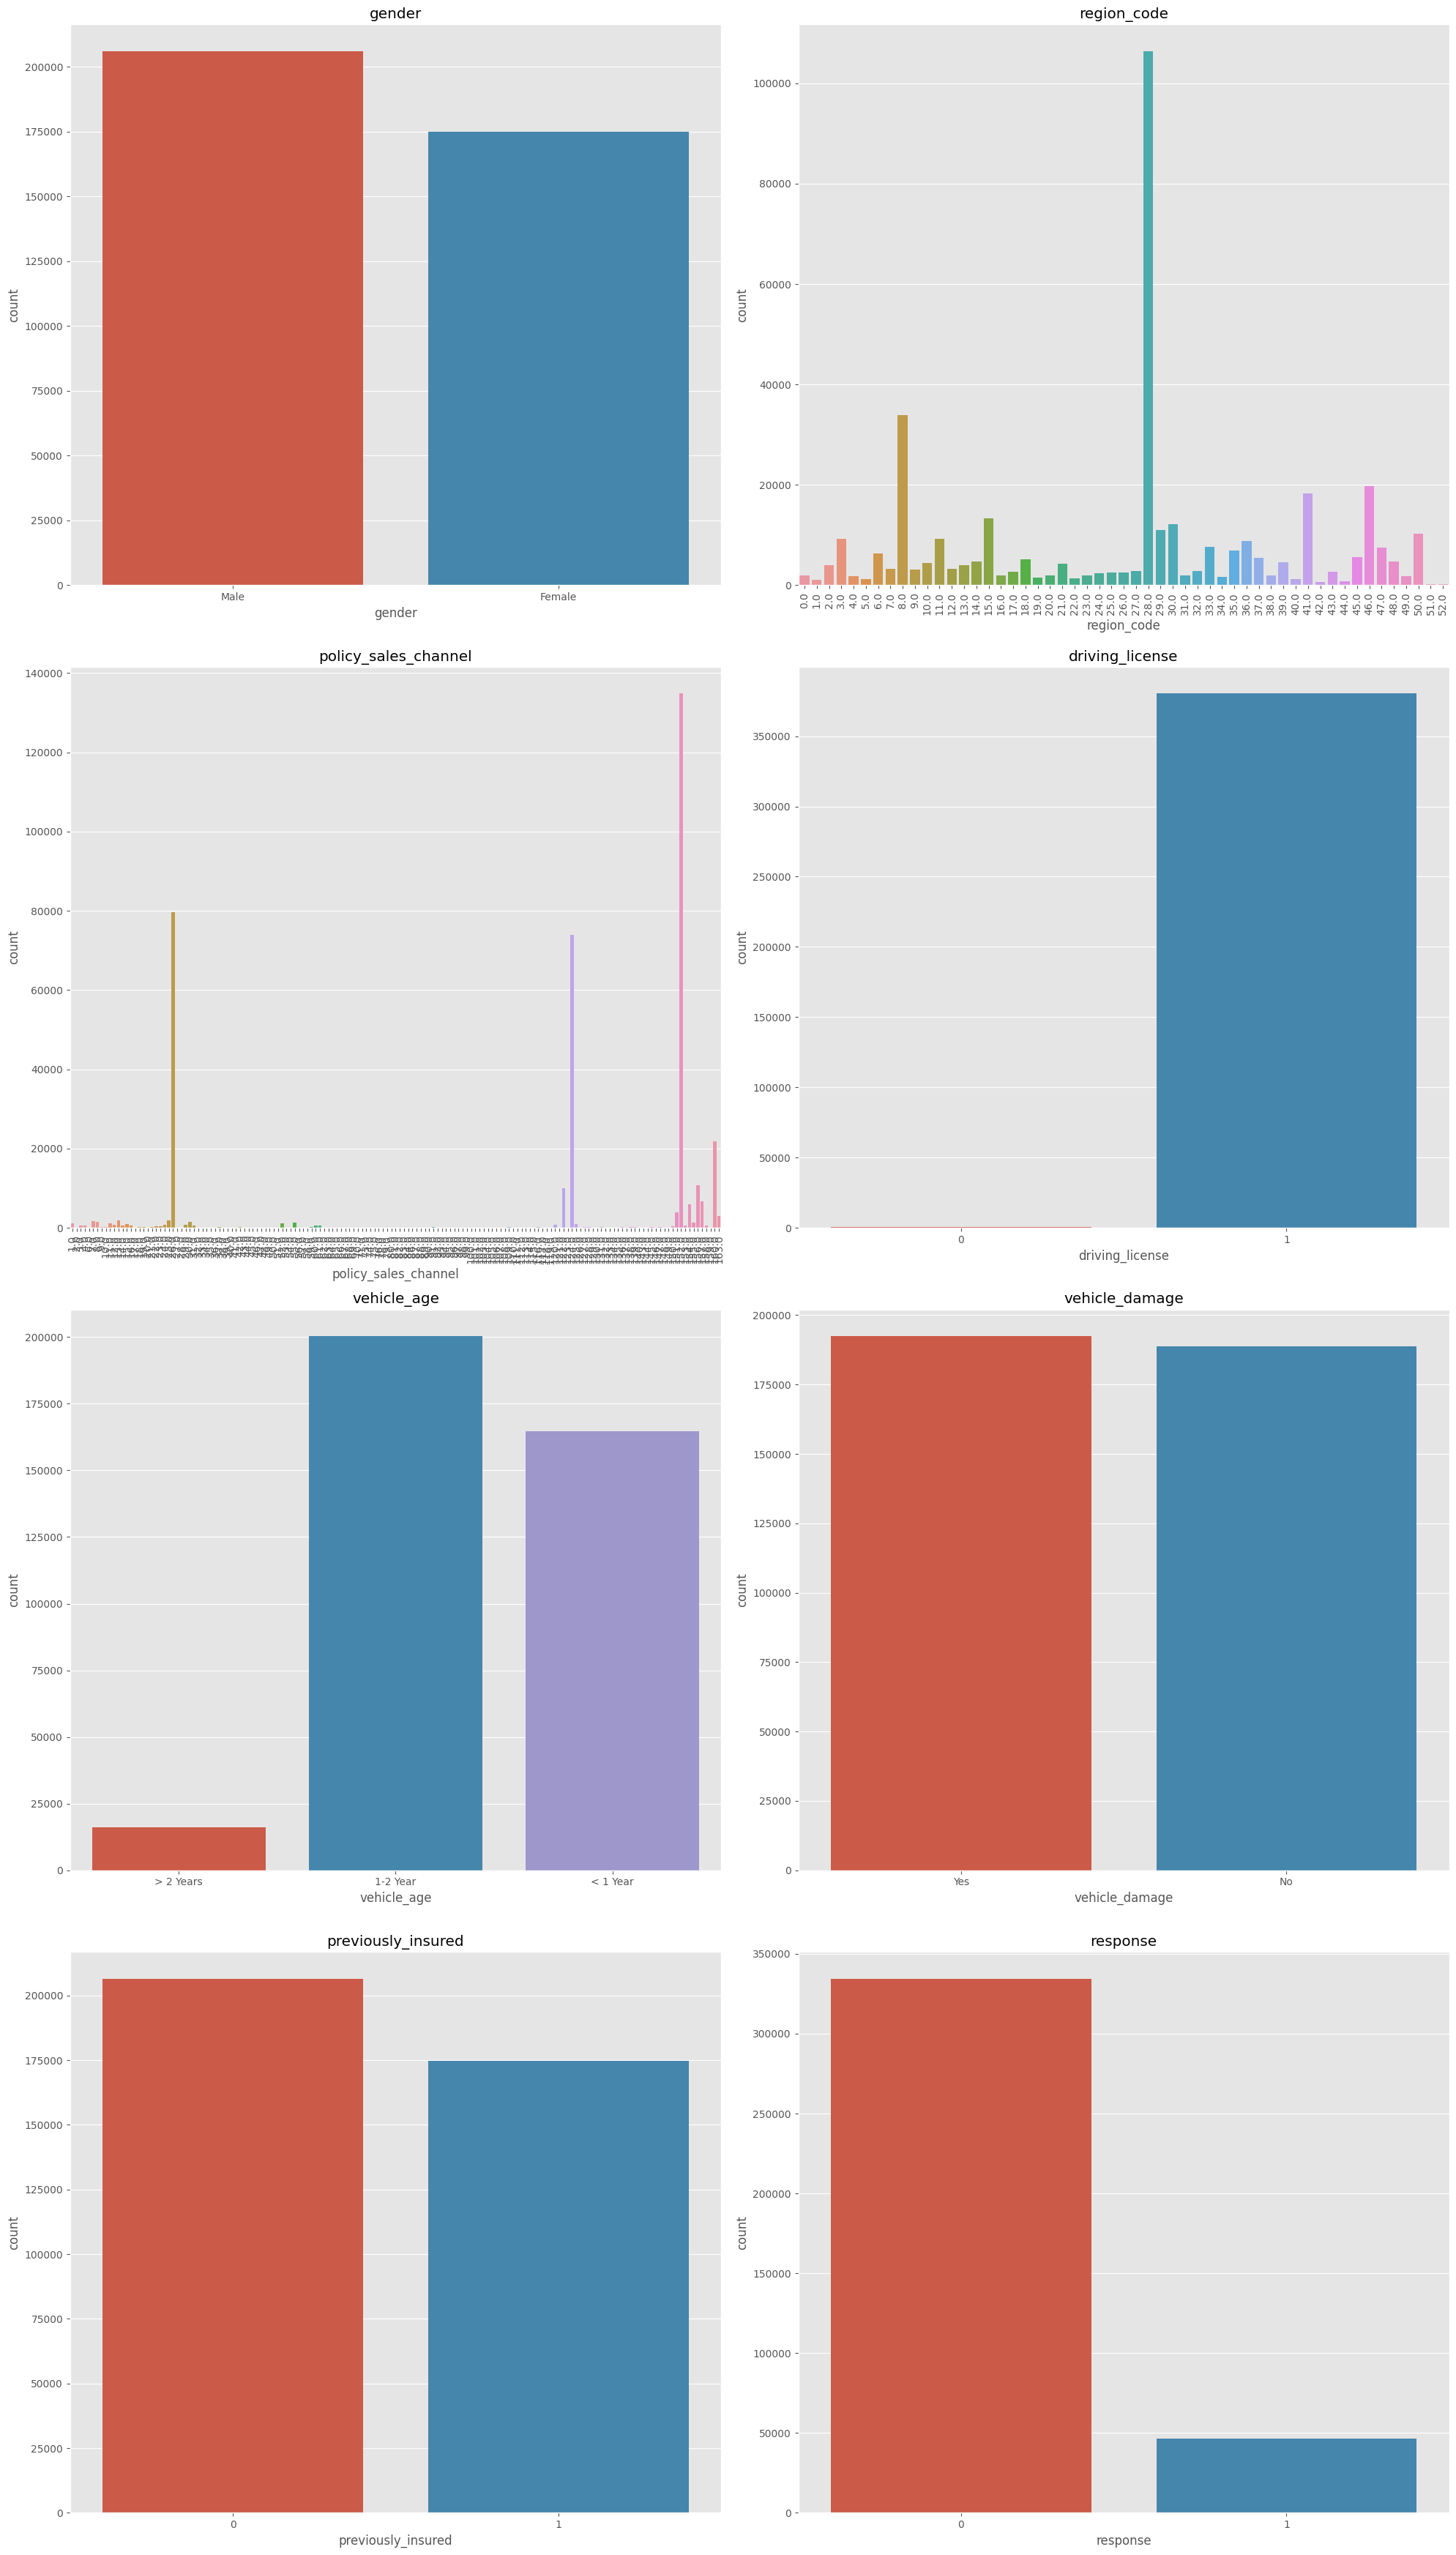

In [25]:
#quanto tem de cada categoria
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 35))

# Loop através das colunas do dataframe e plotagem dos gráficos
for i, column in enumerate(cat_attributes.columns):
    row = i // 2
    col = i % 2
    plot = sns.countplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(column)
    
    num_categories = len(df1[column].unique())
    if num_categories > 50:
        # Rotaciona as labels em 90 graus
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        
# Exibição dos gráficos
plt.tight_layout()
plt.show()

## 3.6 Handling outliers

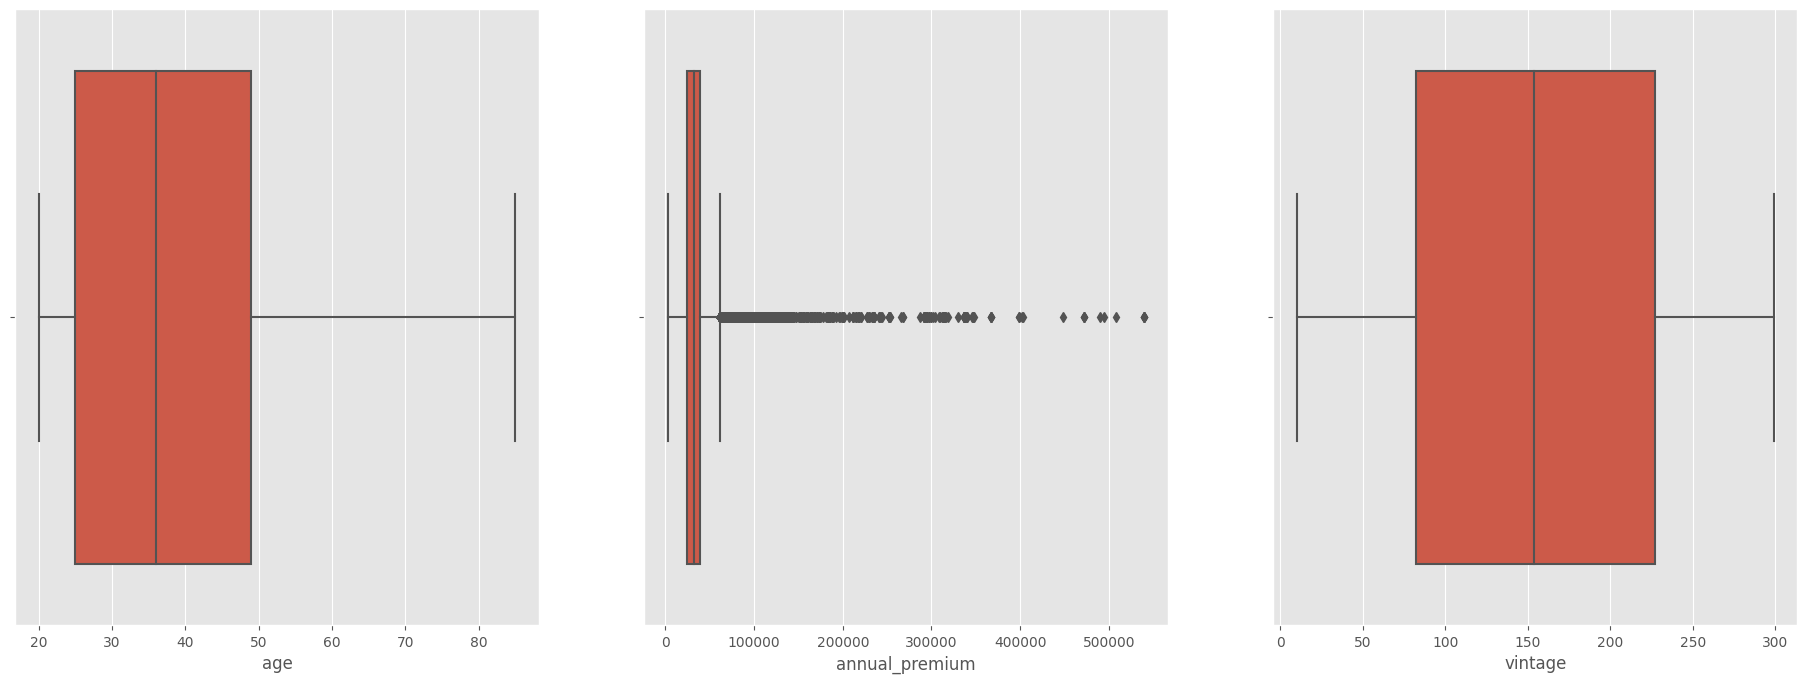

In [26]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.boxplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.boxplot(data=df1, x='annual_premium')

plt.subplot(1, 3, 3)
sns.boxplot(data=df1, x='vintage')

plt.show()

Visually, we can see that we have outliers in 'annual_premium'. First, let's understand what this column exactly means.

* 'annual_premium': the amount customer needs to pay as premium in the year. A premium is a sum of money that the customer needs to pay regularly, in this case annualy, to an insurance company for this guarantee. 

Making some research, i checked that it is possible for a health insurer to have customers who pay different premium amounts, and the difference can be significant. This is because premiums are calculated based on a variety of factors, such as age, health history, type of plan purchased, geographic region, and more.

For example, a younger and healthier customer who purchases a basic plan may pay a much lower premium than an older and less healthy customer who purchases a more comprehensive plan. In addition, some companies may offer corporate health plans to their employees, which may have lower premiums than individual plans, or may be these records refers to someone contracting health insurance plans for all family members.

Therefore, it is normal for there to be a wide variation in premium values among the customers of a health insurer.

I will keep these outliers, but to make a better EDA, I'll create a 'annual_premium_transformed' column, in which i'll apply logarithmich transformation on 'annual_premium'.

In [27]:
df1['annual_premium_transformed'] = np.log(df1['annual_premium'])

# 4.0 Feature Engineering

## 4.1 Hypothesis mindmap

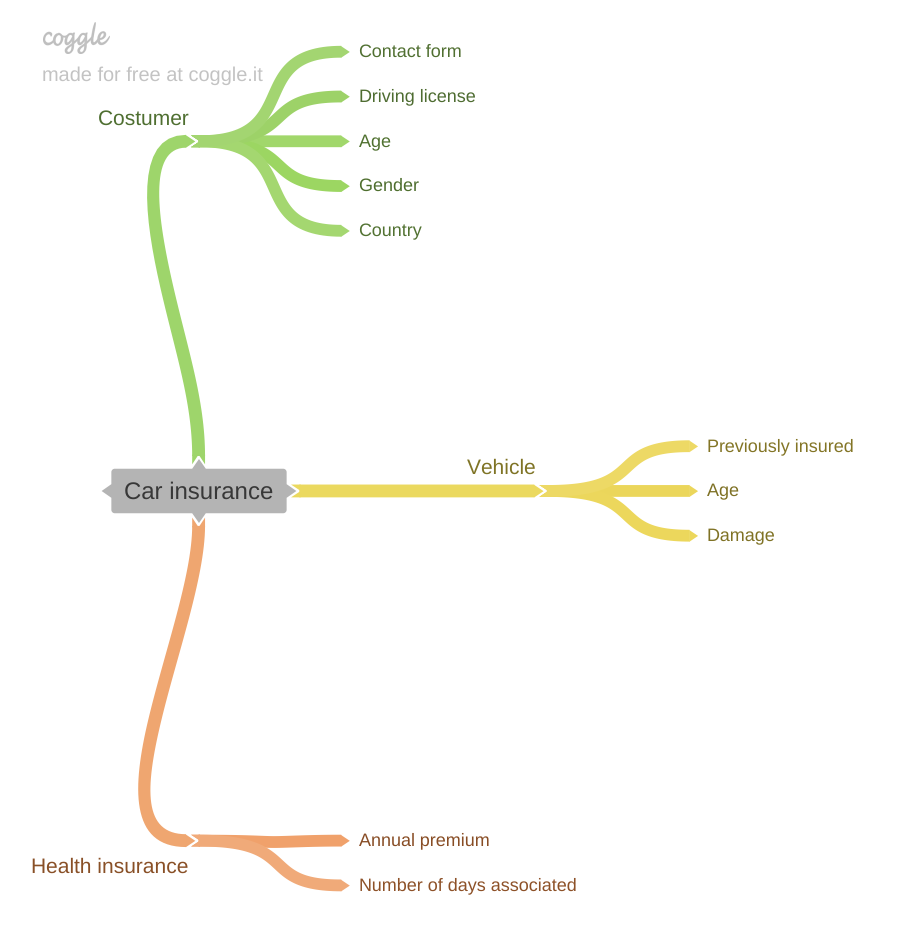

In [28]:
Image('../imgs/hypothesis_mindmap.png')

## 4.2 Hypothesis formulation

### Hypothesis relating predictor variables to response variable

<b> 1.</b> O meio de contato com o cliente influencia em sua resposta. <br>
<b> 2.</b> Mais homens respondem que tem interesse do que mulheres. <br>
<b> 3.</b> A região não influencia na resposta. <br>
<b> 4.</b> Mais de 90% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista. <br>
<b> 5.</b> O público entre 20 e 30 anos demonstra mais interesse do que as outras idades. <br>
<b> 6.</b> Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem. <br>
<b> 7.</b> Clientes com carro mais antigo demonstram menos interesse do que os que possuem carro mais novo. <br>
<b> 8.</b> Clientes que já possuíram o carro prejudicado no passado possuem mais interesse. <br>
<b> 9.</b> Clientes que pagam um prêmio anual maior demonstram menos interesse no seguro de carros pois provavelmente já possuem um seguro. <br>
<b> 10.</b> Clientes que estão associados a mais tempo com a empresa demonstram mais interesse, pois confiam mais. <br>

### Hypothesis relating predictor variables

<b> 1.</b> Carros mais antigos sofreram mais danos do que carros mais novos. <br>
<b> 2.</b> Clientes que pagam um prêmio anual maior possuem mais seguro do que os que pagam prêmios menores. <br>
<b> 3.</b> Clientes mais velhos pagam um prêmio anual maior.  <br>
<b> 4.</b> Clientes mais velhos estão associados a mais tempo com o seguro (já não querem tanta instabilidade) </b>

### Final list of hypothesis

<b> 1.</b> O meio de contato com o cliente influencia em sua resposta. <br>
<b> 2.</b> Mais homens respondem que tem interesse do que mulheres. <br>
<b> 3.</b> A região não influencia na resposta. <br>
<b> 4.</b> Mais de 90% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista. <br>
<b> 5.</b> O público entre 20 e 30 anos demonstra mais interesse do que as outras idades. <br>
<b> 6.</b> Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem. <br>
<b> 7.</b> Clientes com carro mais antigo demonstram menos interesse do que os que possuem carro mais novo. <br>
<b> 8.</b> Clientes que já possuíram o carro prejudicado no passado possuem mais interesse. <br>
<b> 9.</b> Clientes que pagam um prêmio anual maior demonstram menos interesse no seguro de carros pois provavelmente já possuem um seguro. <br>
<b> 10.</b> Clientes que estão associados a mais tempo com a empresa demonstram mais interesse, pois confiam mais. <br>
<b> 11.</b> Carros mais antigos sofreram mais danos do que carros mais novos. <br>
<b> 12.</b> Clientes que pagam um prêmio anual maior possuem mais seguro do que os que pagam prêmios menores. <br>
<b> 13.</b> Clientes mais velhos pagam um prêmio anual maior.  <br>
<b> 14.</b> Clientes mais velhos estão associados a mais tempo com o seguro (já não querem tanta instabilidade) </b>

## 4.3 Creating new features

In [29]:
df2 = df1.copy()
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,annual_premium_transformed
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1,10.607921
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0,10.420375
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1,10.553049
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0,10.261826
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0,10.221796


##### months_associated

In [30]:
df2['months_associated'] = df2.vintage.apply(lambda x: x//30)

How many months the client is associated with the health insurance service.

##### monthly_premium

In [31]:
df2['monthly_premium'] = df2.annual_premium.apply(lambda x: x//12)

How much the client pay per month to the health insurance company.

##### age_bins

In [135]:
bins = [19, 29, 39, 49, 59, 69, 79, 89]
df2['age_bins'] = pd.cut(df2['age'], bins=bins, 
                         labels=['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89'])

Dividing age in categories.

# 5.0 EDA

In [136]:
df3 = df2.copy()

## 5.1 Univariate Analysis

### 5.1.1 Response variable

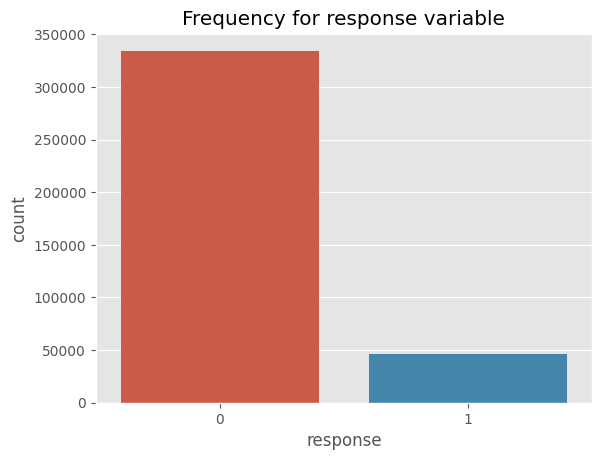

In [137]:
sns.countplot(data=df3, x='response')
plt.title("Frequency for response variable")
plt.show()

Looking this we can see that the response variable is unbalanced. Maybe we'll have to addres it later. Furthermore, we check that most of people that answered the survey doesn't have interest on having an car insurance plan. Let's investigate why later.

### 5.1.2 Numerical variables

In [138]:
num_attributes = df3[['age', 'annual_premium', 'vintage']]

#### Histograms

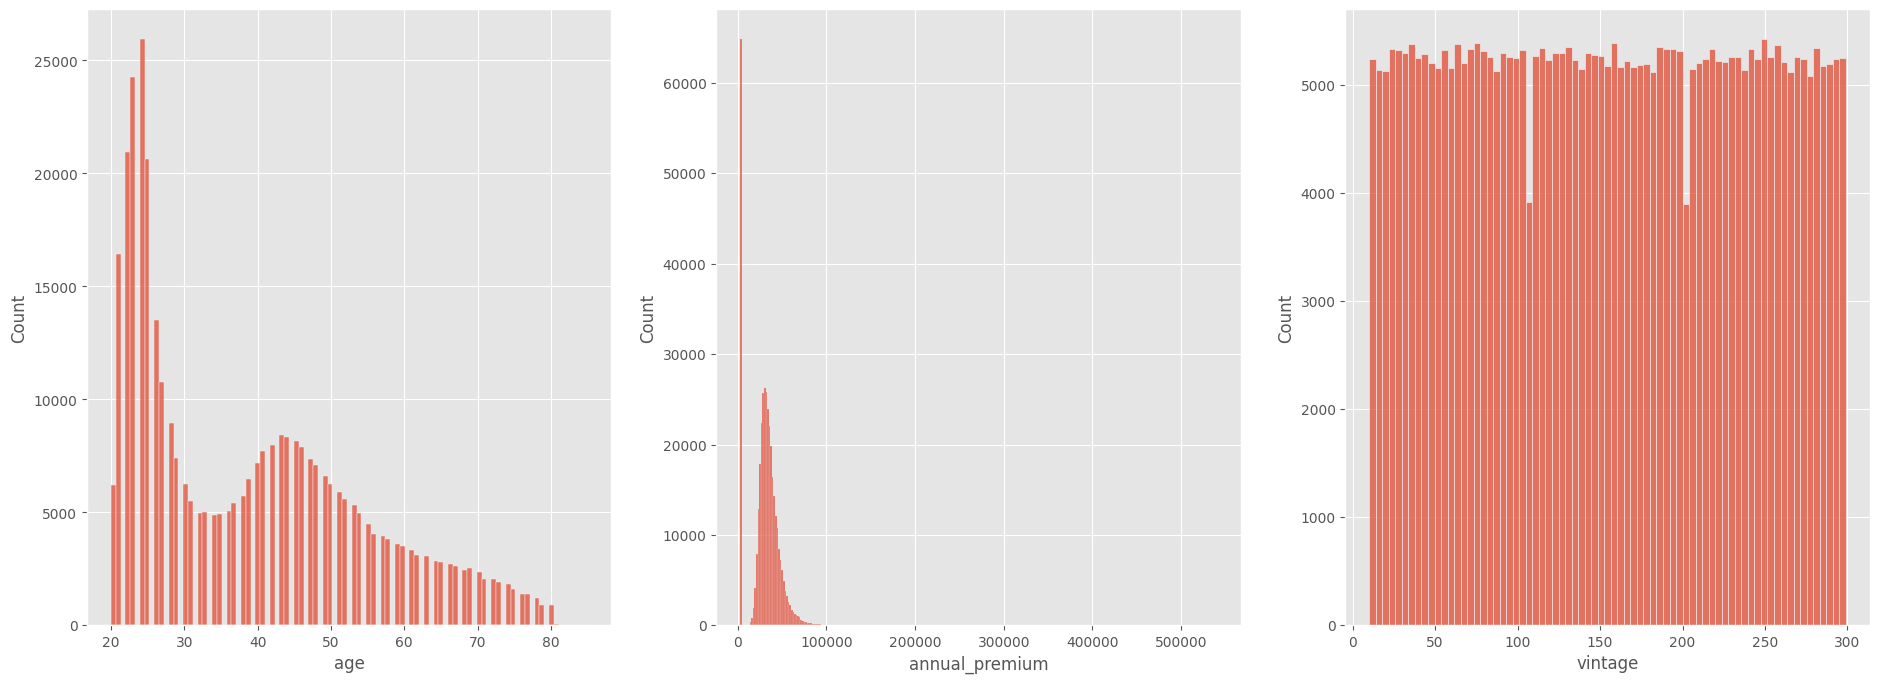

In [139]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.histplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.histplot(data=df1, x='annual_premium', bins=300)

plt.subplot(1, 3, 3)
sns.histplot(data=df1, x='vintage')

plt.show()

###### Kdeplot

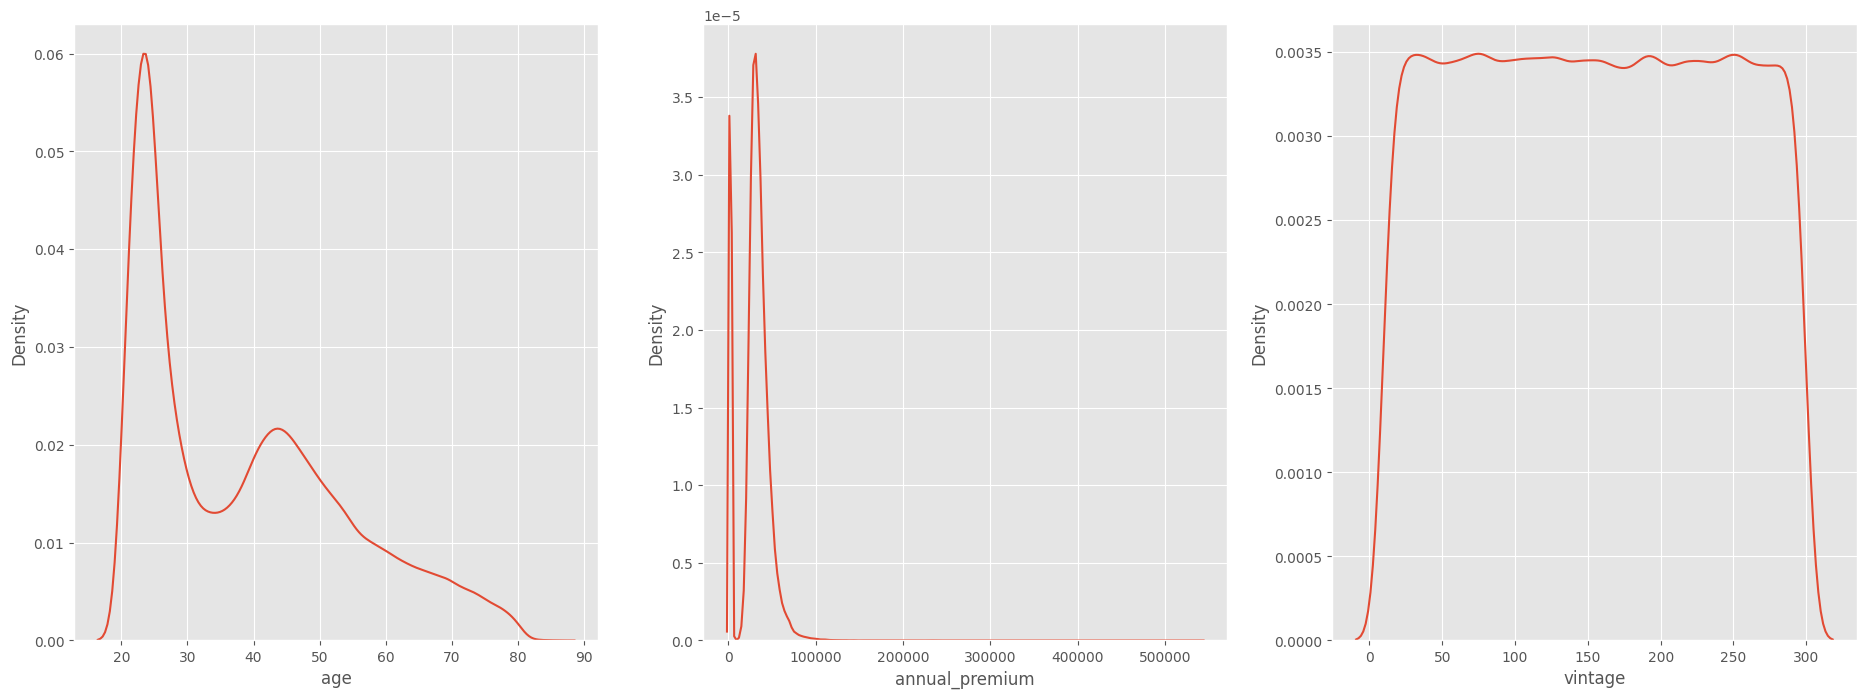

In [140]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.kdeplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.kdeplot(data=df1, x='annual_premium')

plt.subplot(1, 3, 3)
sns.kdeplot(data=df1, x='vintage')

plt.show()

##### Boxplots

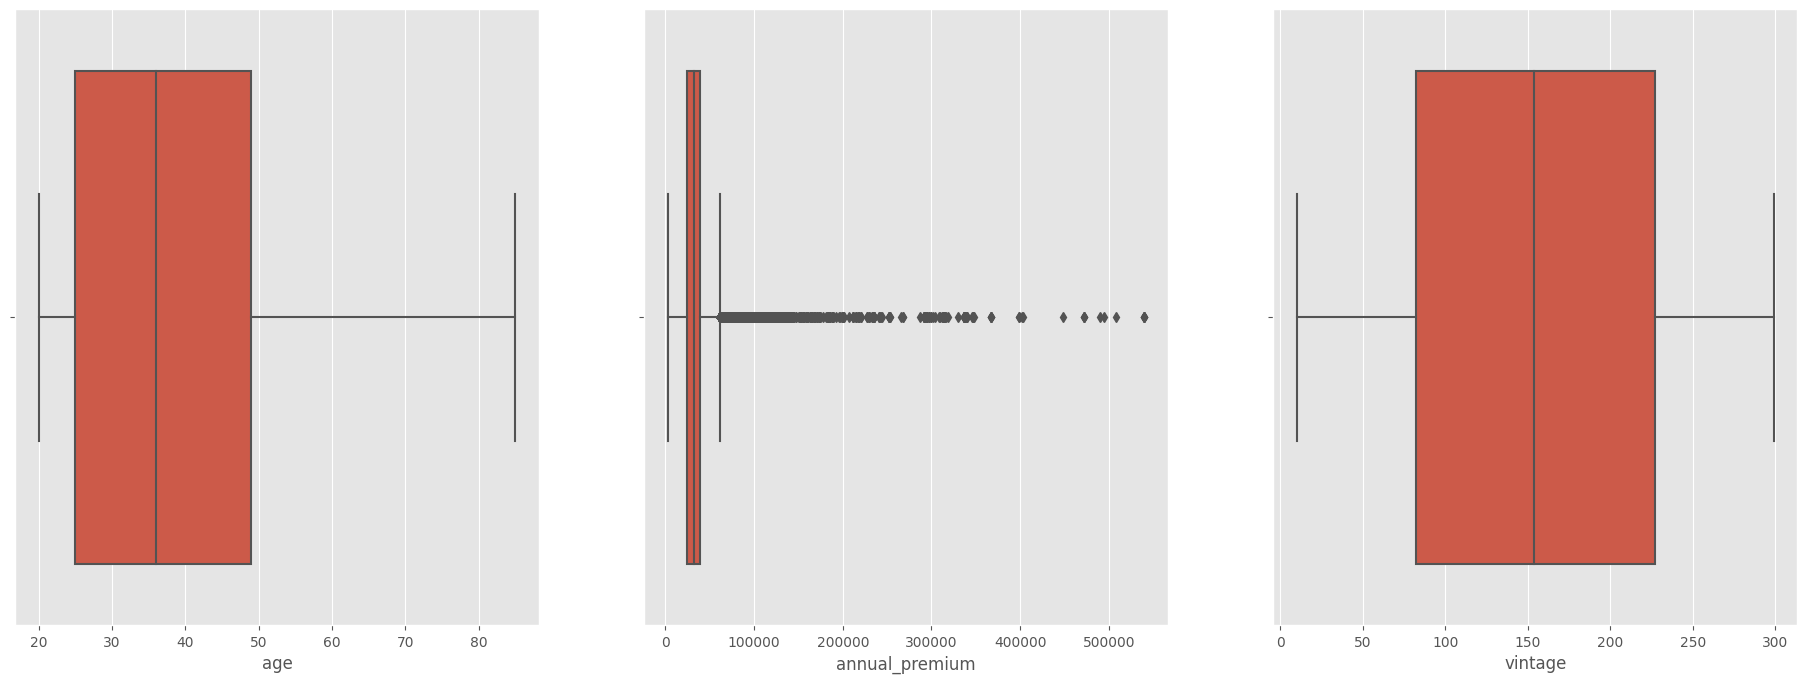

In [141]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.boxplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.boxplot(data=df1, x='annual_premium')

plt.subplot(1, 3, 3)
sns.boxplot(data=df1, x='vintage')

plt.show()

### 5.1.3 Categorical variables

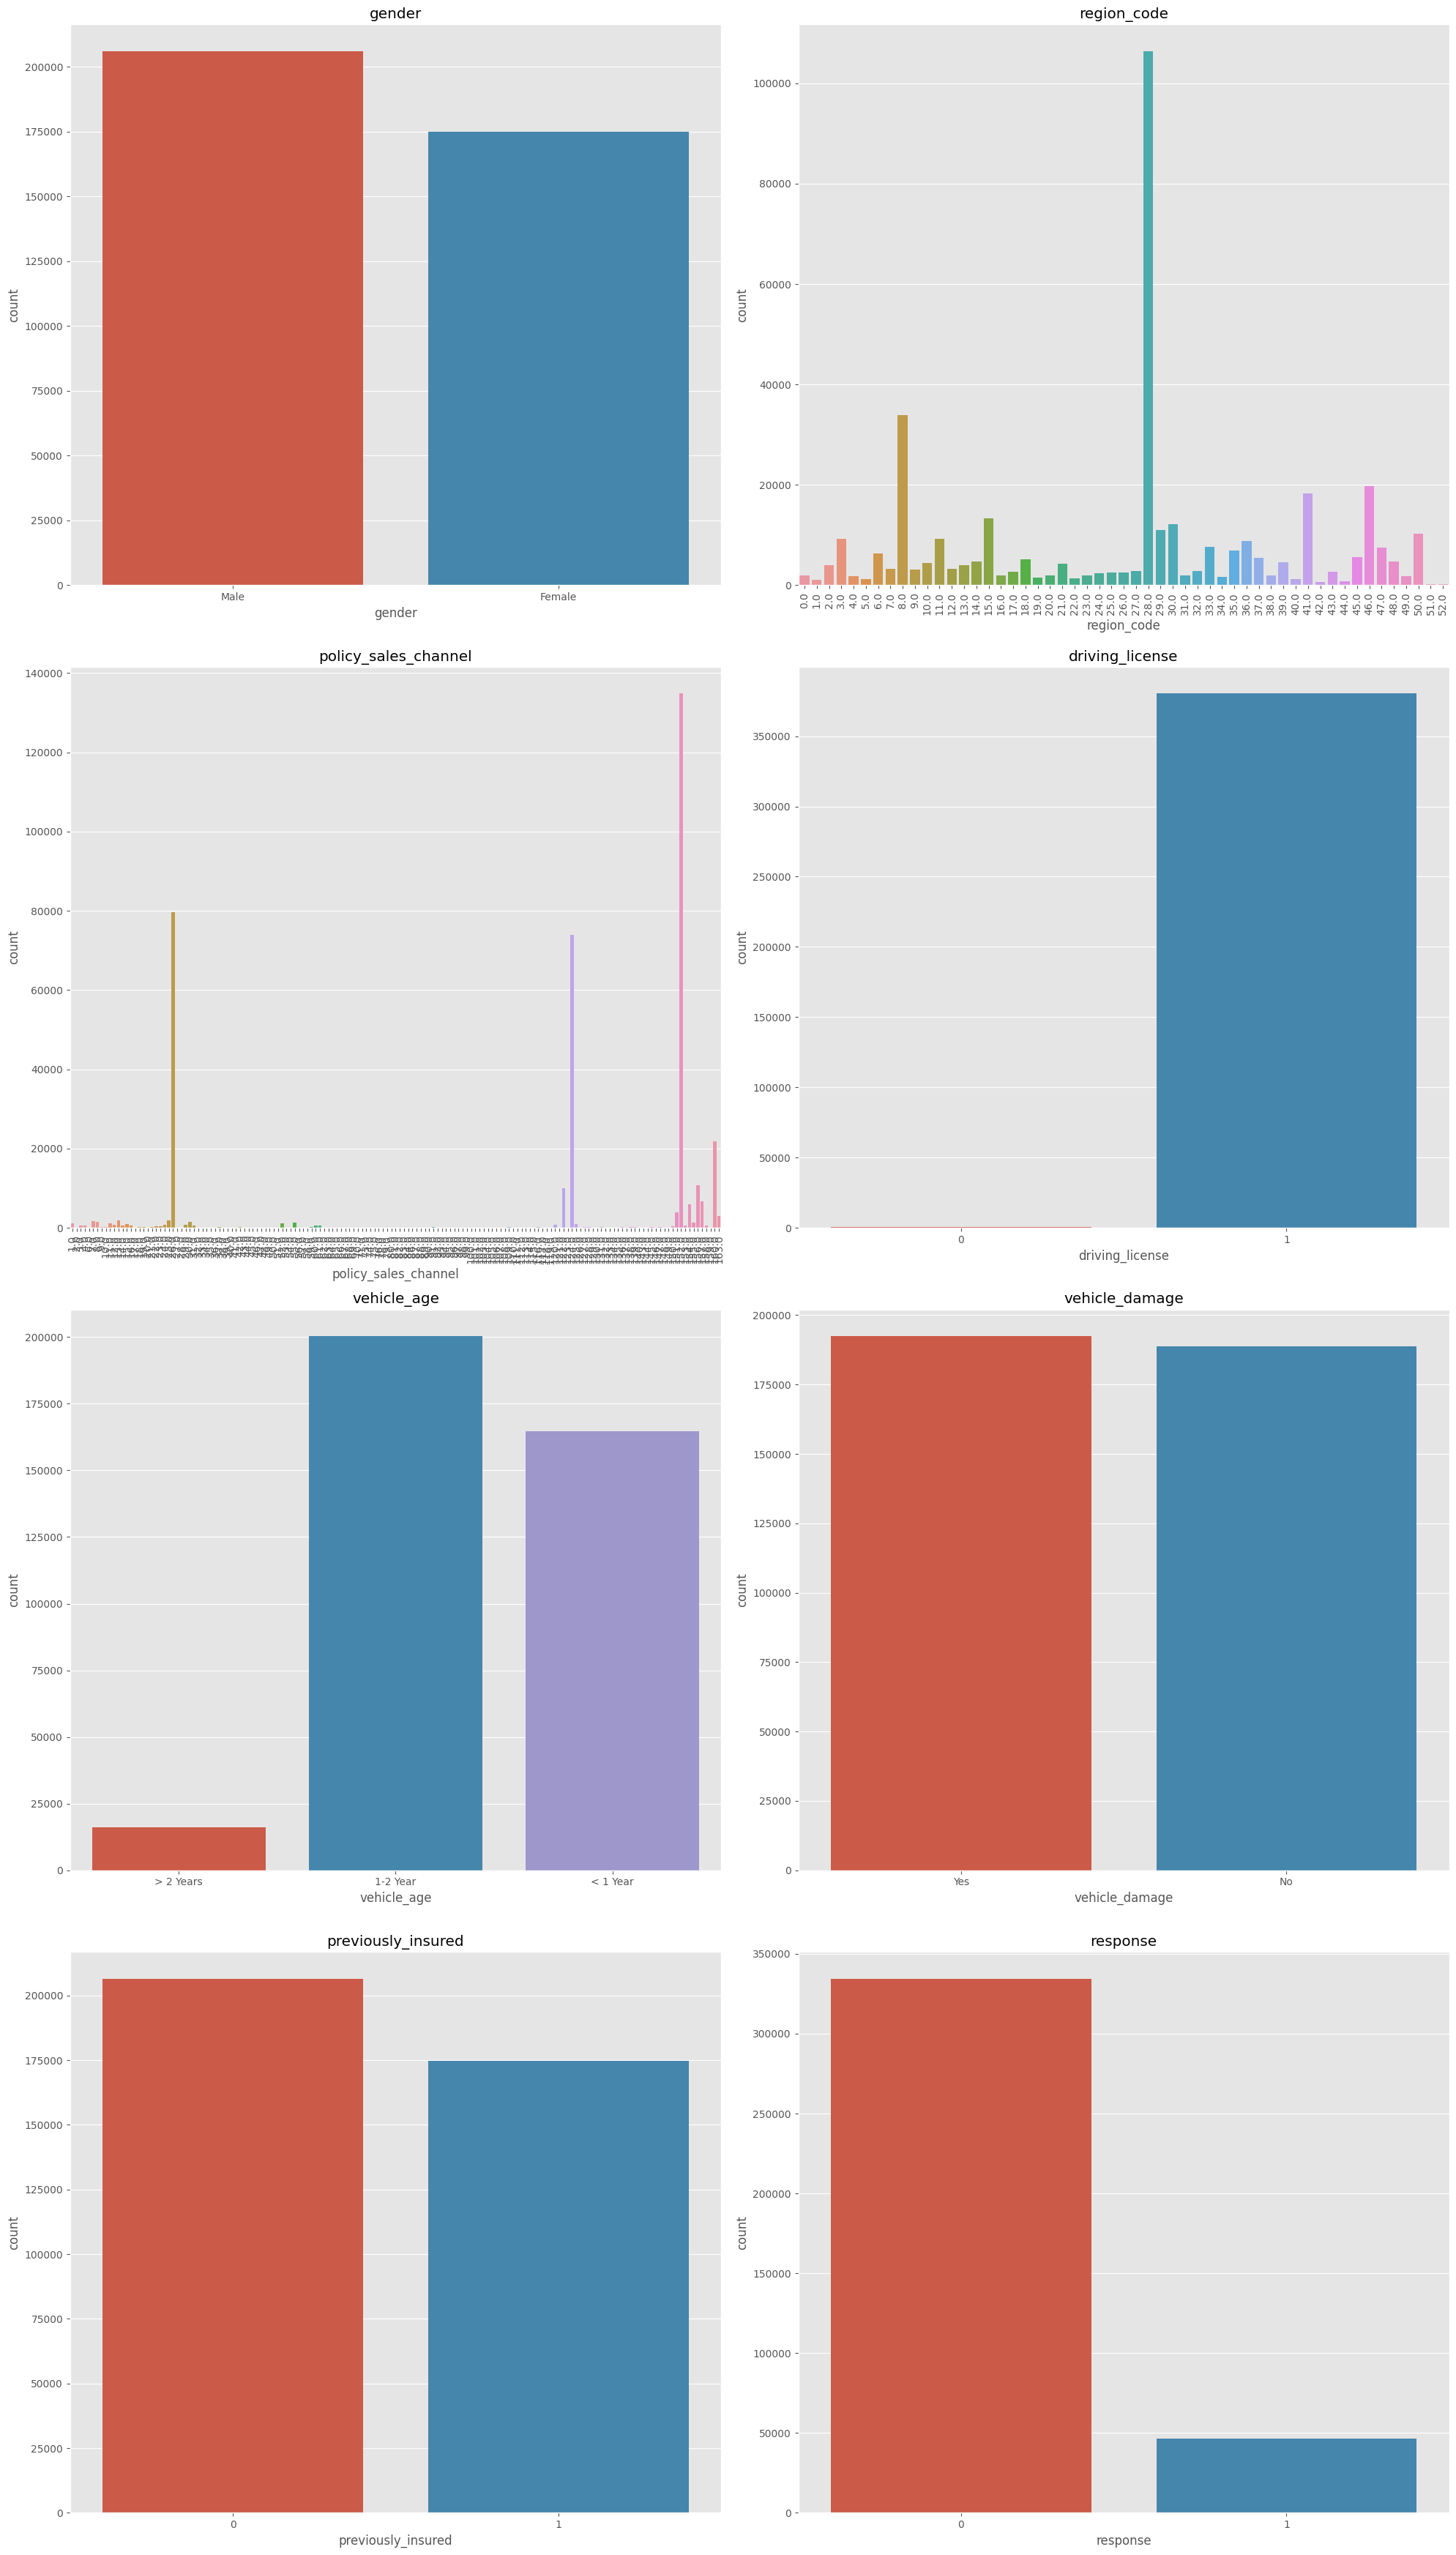

In [142]:
#quanto tem de cada categoria de acordo com a variável resposta
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 35))

# Loop através das colunas do dataframe e plotagem dos gráficos
for i, column in enumerate(cat_attributes.columns):
    row = i // 2
    col = i % 2
    plot = sns.countplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(column)
    
    num_categories = len(df1[column].unique())
    if num_categories > 50:
        # Rotaciona as labels em 90 graus
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        
# Exibição dos gráficos
plt.tight_layout()
plt.show()

## 5.2 Bivariate Analysis

<b> 1.</b> O meio de contato com o cliente influencia em sua resposta. <br>
<b> 2.</b> Mais homens respondem que tem interesse do que mulheres. <br>
<b> 3.</b> A região não influencia na resposta. <br>
<b> 4.</b> Clientes mais velhos pagam um prêmio anual maior.<br>
<b> 5.</b> O público entre 20 e 30 anos demonstra mais interesse do que as outras idades. <br>
<b> 6.</b> Os clientes que não possuem seguro de carro demonstraram mais interesse do que os que já possuem. <br>
<b> 7.</b> Clientes com carro mais antigo demonstram menos interesse do que os que possuem carro mais novo. <br>
<b> 8.</b> Clientes que já possuíram o carro prejudicado no passado possuem mais interesse. <br>
<b> 9.</b> Clientes que pagam um prêmio anual maior demonstram menos interesse no seguro de carros pois provavelmente já possuem um seguro. <br>
<b> 10.</b> Clientes que estão associados a mais tempo com a empresa demonstram mais interesse, pois confiam mais. <br>
<b> 11.</b> Carros mais antigos sofreram mais danos do que carros mais novos. <br>
<b> 12.</b> Clientes que pagam um prêmio anual maior possuem mais seguro do que os que pagam prêmios menores. <br>
<b> 13.</b> Mais de 90% dos clientes que dizem ter interesse no seguro já possuem carteira de motorista.  <br>
<b> 14.</b> Clientes mais velhos estão associados a mais tempo com o seguro (já não querem tanta instabilidade) </b>

### H1. O meio de contato com o cliente influencia em sua resposta.
**VERDADEIRA** Existe uma relação estatisticamente significativa entre o meio de contato e a resposta do cliente.

In [143]:
contingency_table = pd.crosstab(df3['policy_sales_channel'], df3['response'])

In [144]:
#getting only rows that has at least five observations in each cell
index = set()

for i in range(contingency_table.shape[0]):
    values = contingency_table.iloc[i].values
    if values[0] >= 5 and values[1] >= 5:
        index.add(i)
        
index = list(index)

contingency_table = contingency_table.iloc[index]

In [145]:
stat, p, dof, expected = chi2_contingency(contingency_table)

print(f'P-value: {p:.3f}')

if p < 0.05:
    print('There is a significant association between contact method and response.')
else:
    print('There is no significant association between contact method and response.')

P-value: 0.000
There is a significant association between contact method and response.


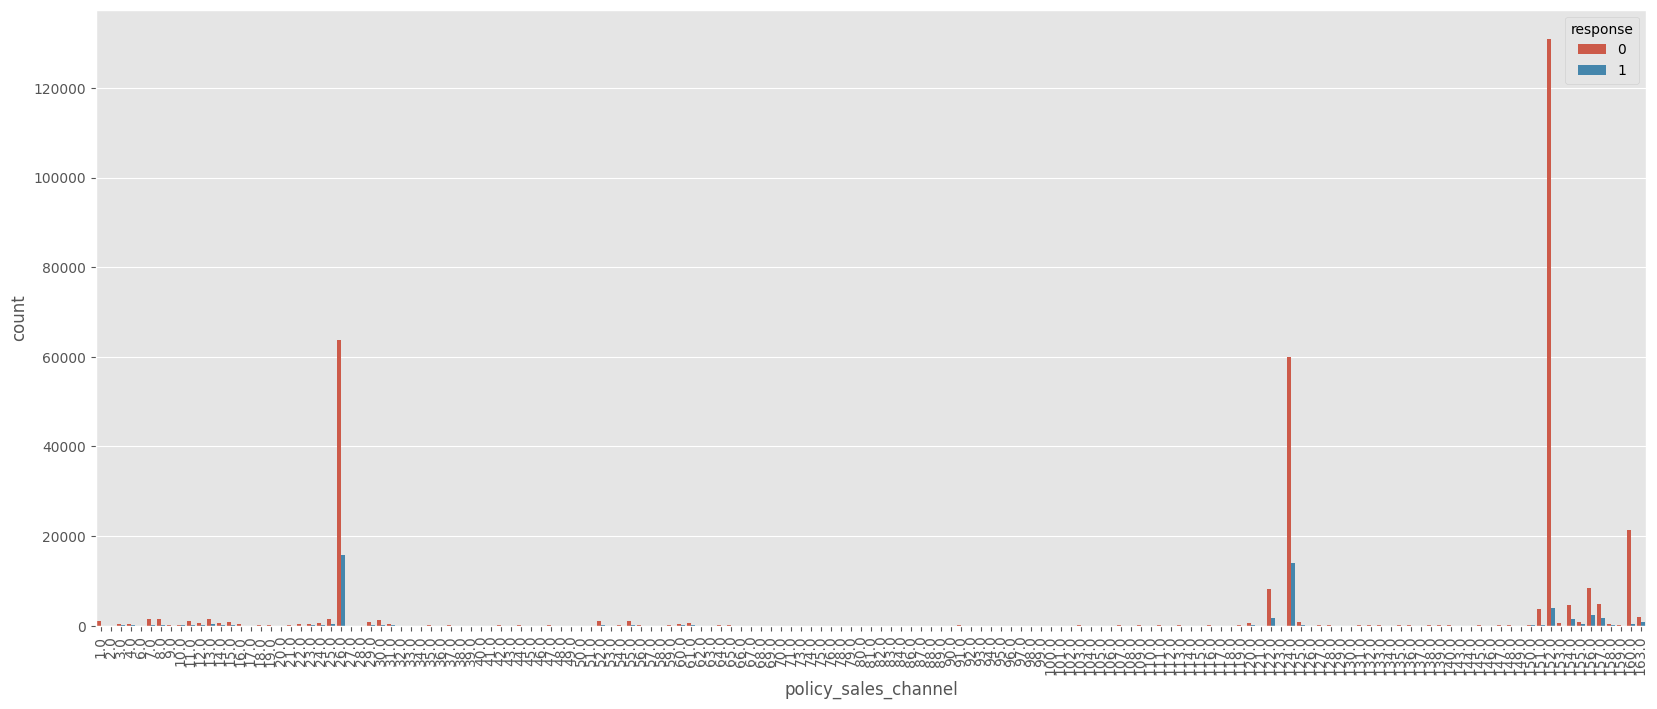

In [146]:
plt.figure(figsize=(20, 8))
sns.countplot(df3, x='policy_sales_channel', hue='response')
plt.xticks(rotation=90)
plt.show()

### H2. Mais homens respondem que tem interesse do que mulheres.
**VERDADEIRA** Proporcionalmente, homens respondem mais 'sim' do que mulheres, apesar dessa diferença ser pequena. 

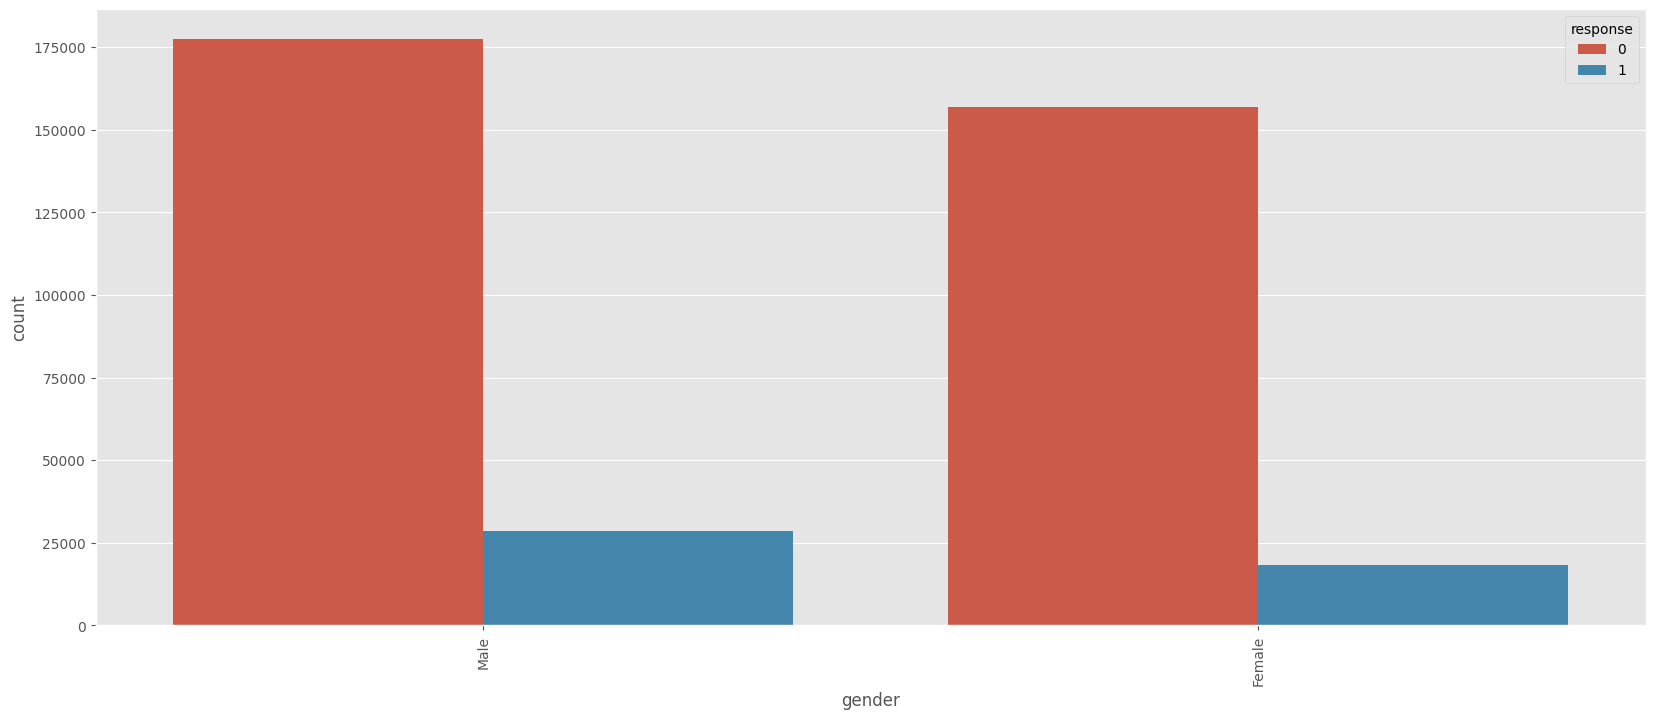

In [147]:
countplot(df3, 'gender', 'response')

Apearently, doesn't have any relationship between gender and the interest in car insurance services.

Let's check the proportion of '1' responses for each gender.

In [148]:
gender_response = pd.DataFrame()
gender_response['male'] = df3[df3['gender'] == 'Male'].response.value_counts(normalize=True)
gender_response['female'] = df3[df3['gender'] == 'Female'].response.value_counts(normalize=True)

gender_response

,male,female
0,0.861589,0.896098
1,0.138411,0.103902


We see that, proportionally, mens answers more '1' than woman. But, the difference between these proportions is very small, so, despite that there are a relation between gender and response, it's very weak.

Let's make some hypothesis test to validate our thoughts.

In [149]:
stat, p, dof, expected = chi2(df3, 'gender', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between gender and response.')
else:
    print('There is no statistically significant relation between gender and response.')

print("Cramer'v: ", cramer_v(df3, 'gender', 'response'))

P-value: 7.665800628415621e-230
There is a statistically significant relation between gender and response.
Cramer'v:  0.05243195443576884


Beside the fact that we have and relation between gender and response, this association is very weak and doesn't matter that much.

### H3. A região não influencia na resposta. 
**FALSO** A região influencia na resposta de interesse em seguro de veículos.

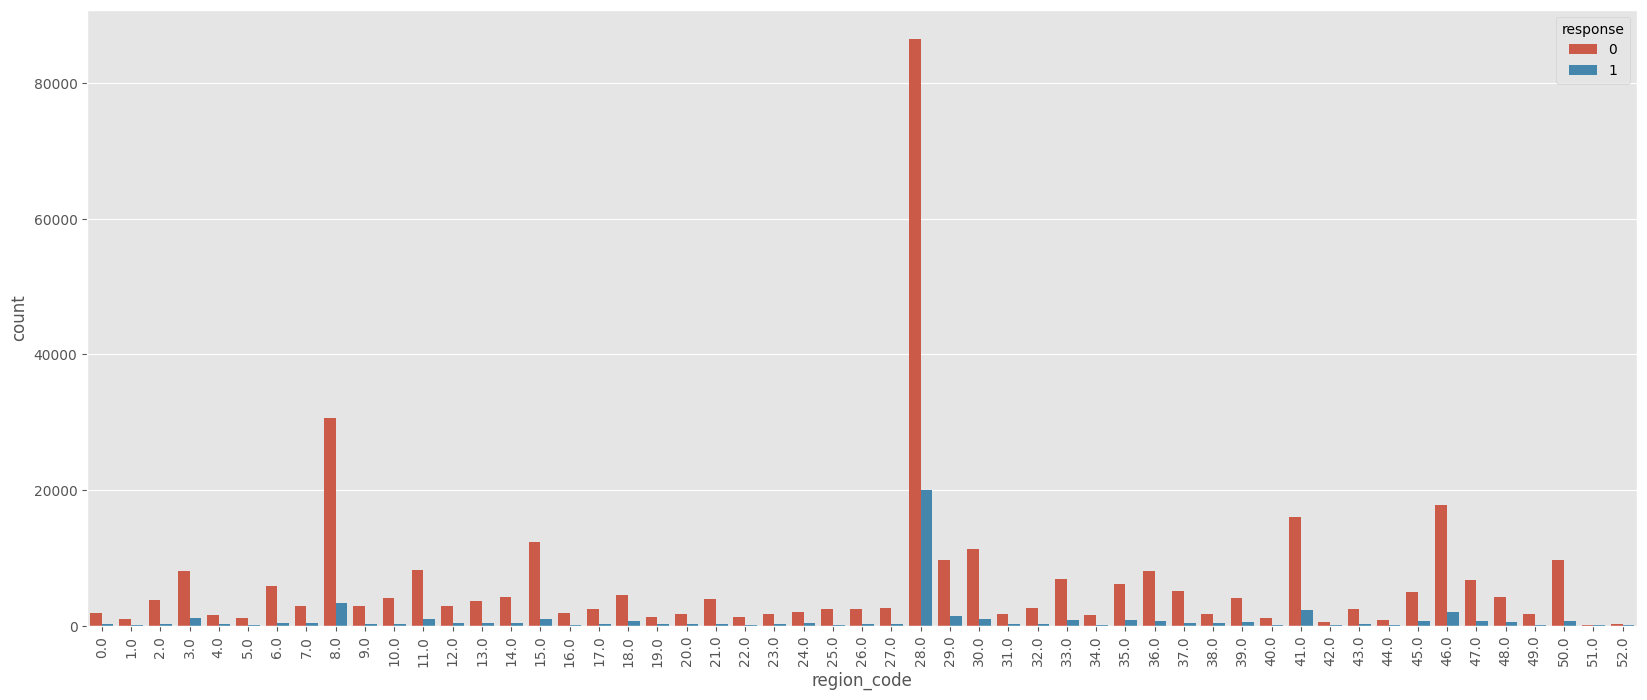

In [150]:
countplot(df3, 'region_code', 'response')

Visually we can't conclude so much. Let's see the proportion of answers for each region_code.

In [151]:
grouped_region_code = pd.DataFrame(df3.groupby("region_code")["response"].value_counts(normalize=True))
grouped_region_code.rename(columns={'response':'proportion'}, inplace=True)
grouped_region_code.reset_index(inplace=True)
grouped_region_code = pd.pivot(grouped_region_code, index='response', columns='region_code', values='proportion').T
grouped_region_code.reset_index(inplace=True)

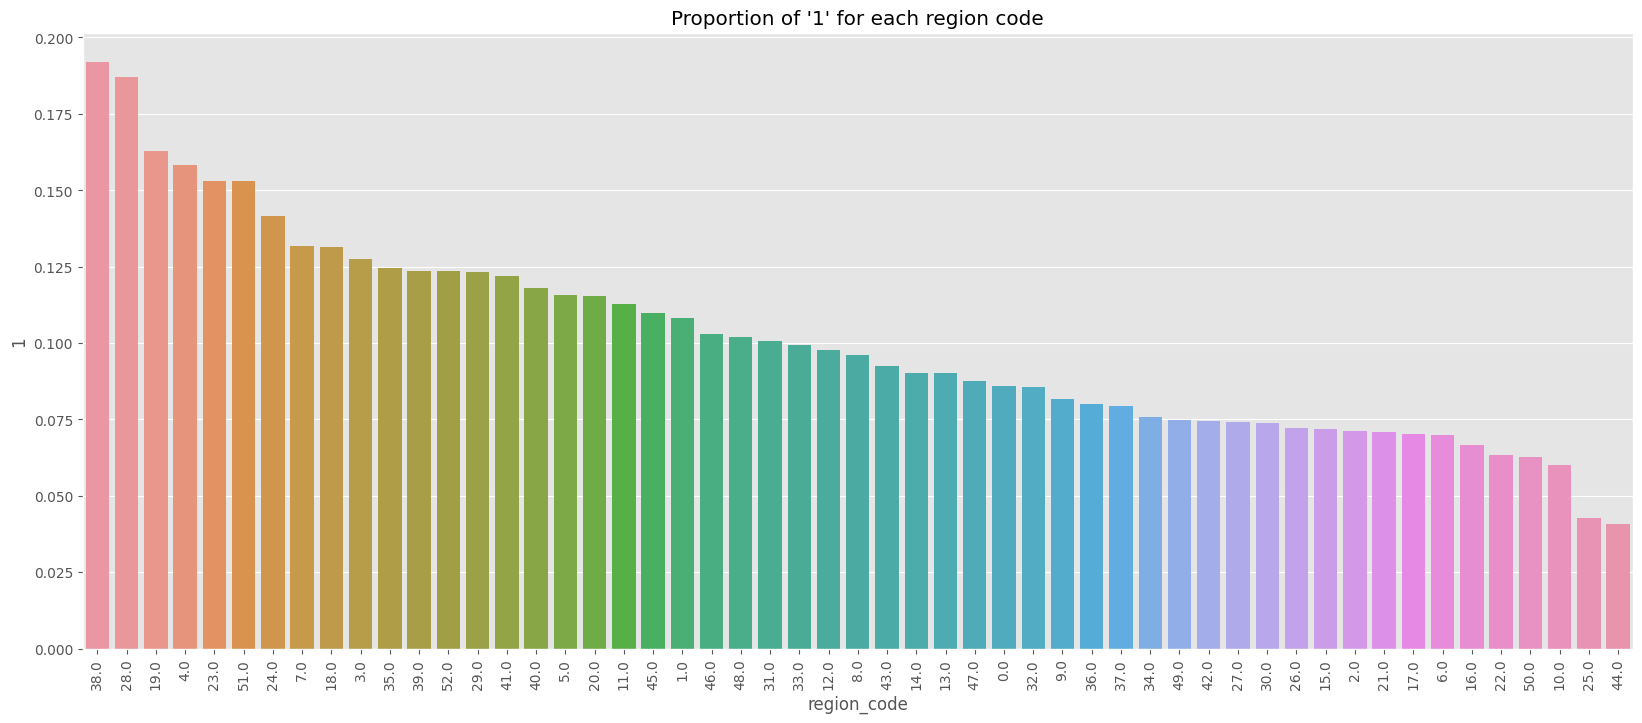

In [152]:
plt.figure(figsize=(20, 8))
sns.barplot(grouped_region_code, x='region_code', y=1, 
            order=grouped_region_code.sort_values(by=[1], ascending=False)['region_code'])
plt.xticks(rotation=90)
plt.title("Proportion of '1' for each region code")
plt.show()

With this graph, that shows proportion of 1 for each region code we can see that this proportion differs from one region code to another. In some cases, the proportion in X is the double, or even the triple, than in Y. So, seems that the region code and the response are related to.

To check that, let's make an hypothesis test.

In [153]:
stat, p, dof, expected = chi2(df3, 'region_code', 'response')

print(f'P-value: {p}')
if p < 0.05:
    print('There is a statistically significant relation between region code and response.')
else:
    print('There is no statistically significant relation between region code and response.')

print("Cramer'v: ", cramer_v(df3, 'region_code', 'response'))

P-value: 0.0
There is a statistically significant relation between region code and response.
Cramer'v:  0.13809524215806745


### H4. Clientes mais velhos pagam um prêmio anual maior. 
**FALSO** 

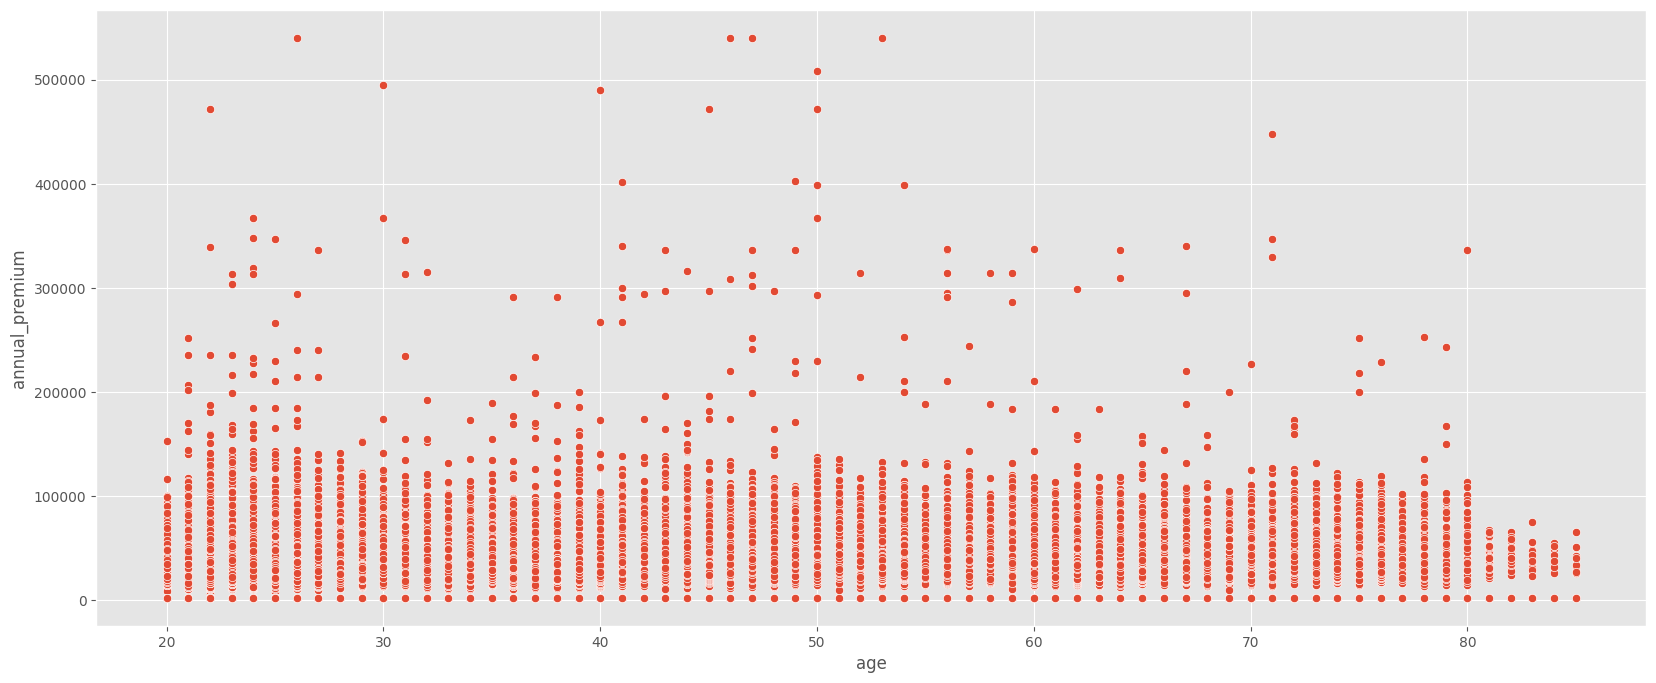

In [154]:
scatterplot(df3, 'age', 'annual_premium')

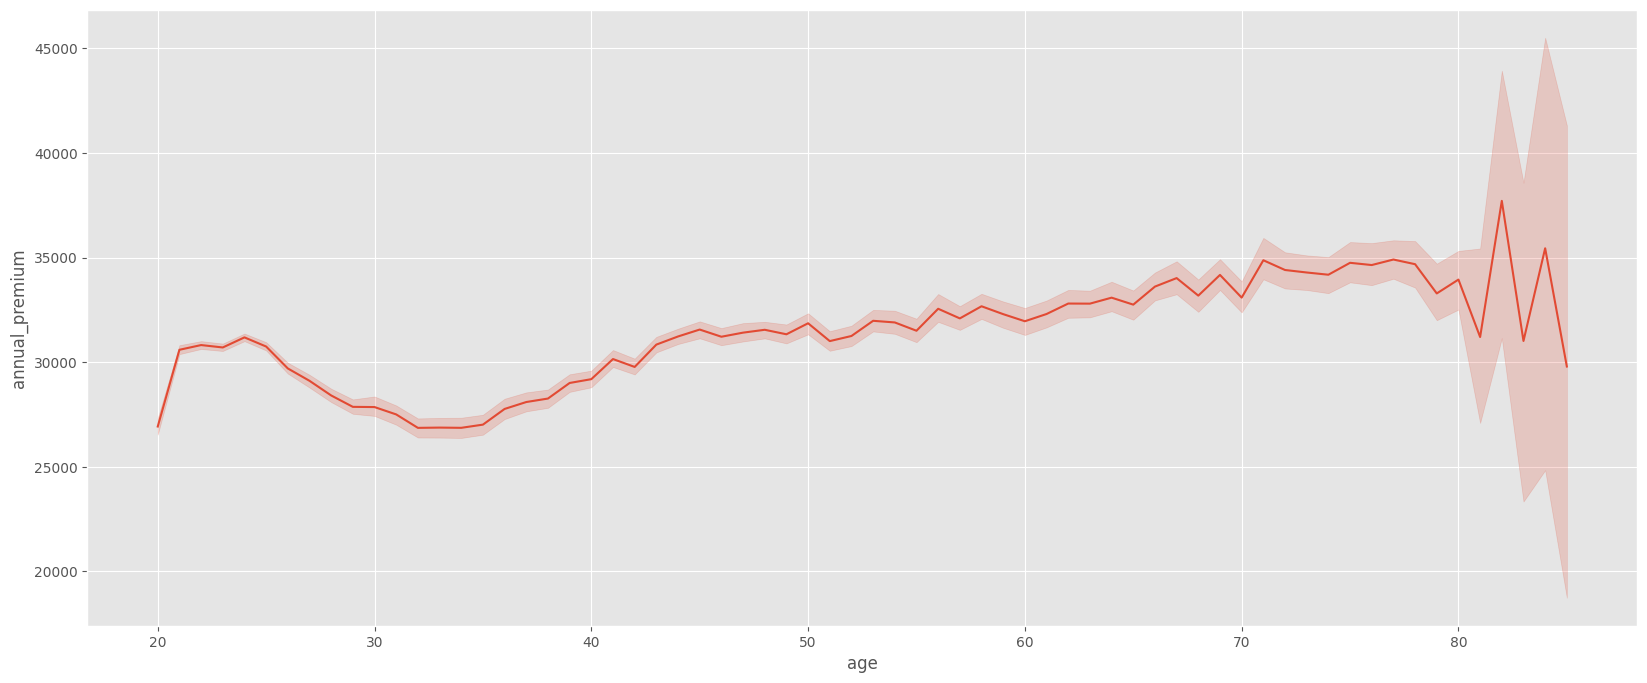

In [155]:
plt.figure(figsize=(20,8))
sns.lineplot(df3, x='age', y='annual_premium')
plt.show()

In [156]:
grouped = df3.groupby('age_bins')['annual_premium']
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
age_bins,,,,,,,,
20-29,155203.0,30174.882876,14939.172358,2630.0,24728.0,30565.0,37188.00,540165.0
30-39,54253.0,27666.887490,17481.946706,2630.0,20100.0,29946.0,37362.00,495106.0
40-49,76846.0,30824.520522,18107.832257,2630.0,24689.0,32741.0,40600.75,540165.0
50-59,48034.0,31841.764604,19296.148975,2630.0,24833.0,33843.0,42409.00,540165.0
60-69,29023.0,32999.416497,19200.952536,2630.0,25501.0,34669.0,44044.50,340439.0
70-79,16712.0,34289.866443,19710.550726,2630.0,26486.5,35218.5,44925.25,448156.0
80-89,1038.0,33812.347784,20831.356984,2630.0,26327.5,33814.0,44696.25,336395.0


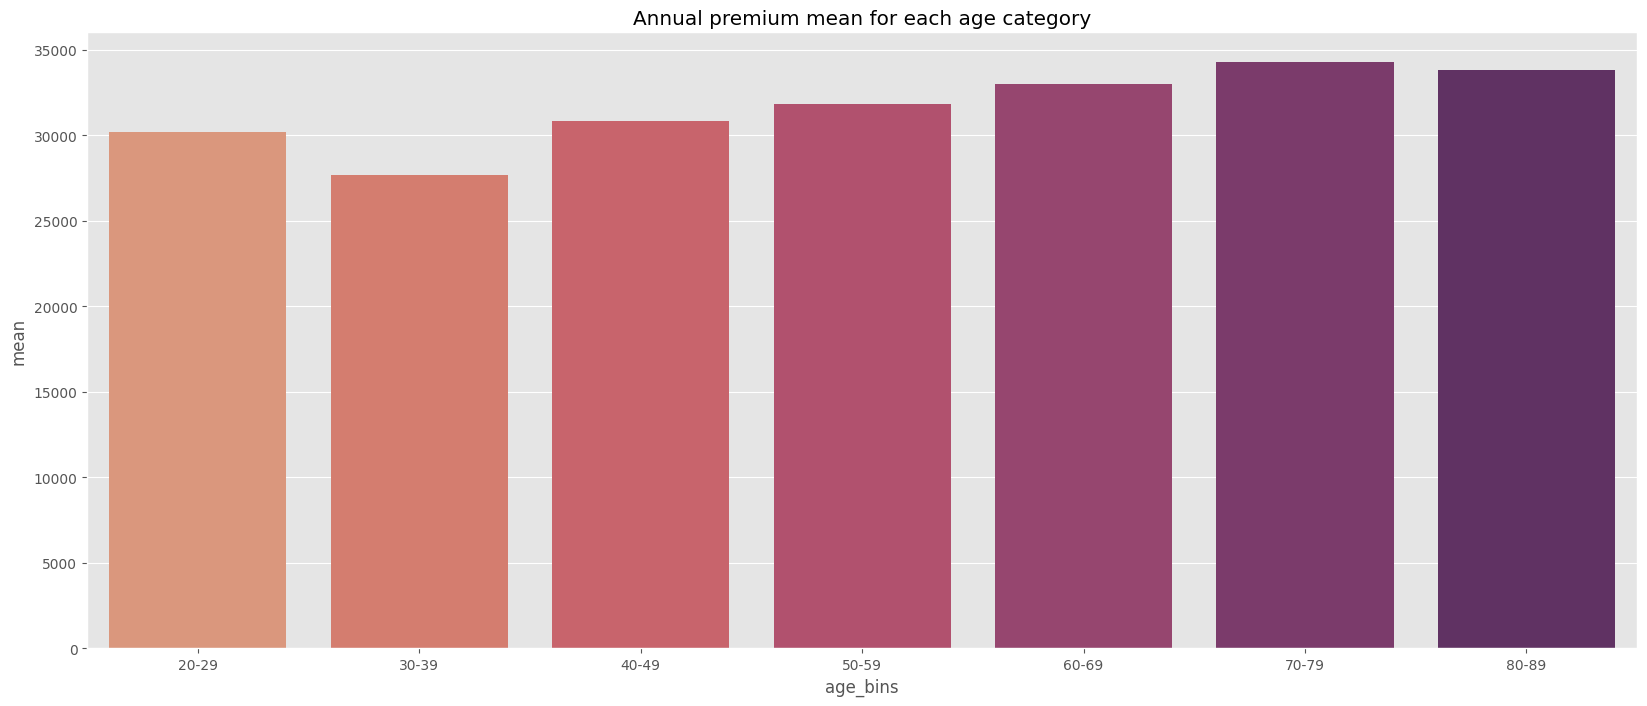

In [171]:
age_bins_means = grouped.describe().reset_index()[['age_bins', 'mean']]

plt.figure(figsize=(20, 8))
sns.barplot(age_bins_means, x='age_bins', y='mean', palette='flare')
plt.title('Annual premium mean for each age category')
plt.show()

Analysing the means for each age category, we have a slighly increase in annual_premium for older groups. But it isn't a clear relation, because we also see that for people between 20-29 years the mean is almost the same for people between 40-49.

In [162]:
# Perform the ANOVA test
result = f_oneway(df3[df3['age_bins'] == '20-29']['annual_premium'],
                  df3[df3['age_bins'] == '30-39']['annual_premium'],
                  df3[df3['age_bins'] == '40-49']['annual_premium'],
                  df3[df3['age_bins'] == '50-59']['annual_premium'],
                  df3[df3['age_bins'] == '60-69']['annual_premium'],
                  df3[df3['age_bins'] == '70-79']['annual_premium'],
                  df3[df3['age_bins'] == '80-89']['annual_premium'])

# Print the result of the test
stats, p = result

if p < 0.05:
    print('There is a statistically significant difference between the means of the different age groups.')
else:
    print('There is no statistically significant difference between the means of the different age groups.')

There is a statistically significant difference between the means of the different age groups.


The ANOVA test only tells us whether there is a statistically significant difference in mean annual premiums between at least two age categories, but it does not tell us which specific age categories have higher means.

In [ ]:
But, looking at the histogram comparing the means, we can conclude that higher ages 

#### future

To determine which specific age categories have higher means, you can perform post-hoc tests. Post-hoc tests allow you to compare the means of all possible pairs of age categories and determine which pairs are significantly different from each other.

In [166]:
model = ols('annual_premium ~ C(age_bins)', data=df3).fit()

# Perform Tukey's HSD test
tukey = sm.stats.multicomp.pairwise_tukeyhsd(endog=df3['annual_premium'], groups=df3['age_bins'], alpha=0.05)

# Print the results of the test
print(tukey.summary())

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
 20-29  30-39 -2507.9954    0.0 -2760.0153 -2255.9755   True
 20-29  40-49   649.6376    0.0   426.7533    872.522   True
 20-29  50-59  1666.8817    0.0  1403.0498  1930.7137   True
 20-29  60-69  2824.5336    0.0  2501.3833   3147.684   True
 20-29  70-79  4114.9836    0.0  3703.6037  4526.3634   True
 20-29  80-89  3637.4649    0.0  2063.8474  5211.0824   True
 30-39  40-49   3157.633    0.0  2874.2802  3440.9859   True
 30-39  50-59  4174.8771    0.0  3858.3038  4491.4505   True
 30-39  60-69   5332.529    0.0  4965.0544  5700.0036   True
 30-39  70-79   6622.979    0.0  6175.9389   7070.019   True
 30-39  80-89  6145.4603    0.0  4562.1462  7728.7743   True
 40-49  50-59  1017.2441    0.0   723.3358  1311.1524   True
 40-49  60-69   2174.896    0.0  1826.7567  2523.0353   True
 40-49  70-79  3465.3459

## 5.3 Multivariate Analysis